In [3]:
#utility
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import scikitplot as skplt
import sklearn.metrics as metrics

from tqdm import tqdm

from sklearn.utils.class_weight import compute_class_weight
from keras.utils import to_categorical
from tensorflow.keras.utils import plot_model

Using TensorFlow backend.


In [4]:
# audio
from scipy.io import wavfile
import librosa
from python_speech_features import mfcc

In [36]:
#Neural net modelling with Keras
from keras.models import Model # creating the model
from keras.models import Sequential
from keras.layers import Input, add, Conv2D, MaxPooling2D, Dense, Activation
from keras.layers import BatchNormalization, Dropout, Flatten, Dense

from keras.regularizers import l2

from keras import optimizers 
from keras.optimizers import Adam

from keras.callbacks import ModelCheckpoint,CSVLogger,LearningRateScheduler # checkpoints

from keras.optimizers import SGD


## Step 1: import the processed data

In [6]:
data = np.load('audiomfcc_normalized_final.npy')
labels = np.load('audiolabels_normalized_final.npy')

In [7]:
print("total dataset", data.shape,labels.shape)

total dataset (7513, 40, 499, 1) (7513, 2)


In [8]:
trLen = round(0.8*(data.shape[0])) #train
tvLen = round(0.9* (data.shape[0])) #validate

trDat = data[0:trLen] 
tvDat = data[trLen:tvLen]
tsDat = data[tvLen:] #test - not to be touched during modelling

trLbl = labels[0:trLen]
tvLbl = labels[trLen:tvLen]
tsLbl = labels[tvLen:]#test - not to be touched during modelling

print("training data shape", trDat.shape)
print("training label shape", trLbl.shape)
print("validation data shape", tvDat.shape)
print("validation label shape", tvLbl.shape)
print("test data shape", tsDat.shape)
print("test label shape", tsLbl.shape)

training data shape (6010, 40, 499, 1)
training label shape (6010, 2)
validation data shape (752, 40, 499, 1)
validation label shape (752, 2)
test data shape (751, 40, 499, 1)
test label shape (751, 2)


## Step 2: Data distribution, Class imbalance

In [11]:
# Data shape, distribution
trLbl_single = np.argmax(trLbl, axis = 1)
df_trLbl = pd.DataFrame(trLbl_single)

tvLbl_single = np.argmax(tvLbl, axis = 1)
df_tvLbl = pd.DataFrame(tvLbl_single)

tsLbl_single = np.argmax(tsLbl, axis = 1)
df_tsLbl = pd.DataFrame(tsLbl_single)

print("bird sound count", 
      "\ntraining data\n", df_trLbl[0].value_counts(),
      "\validation data\n", df_tvLbl[0].value_counts(),
      "\ntest data\n",df_tsLbl[0].value_counts())

bird sound count 
training data
 0    4485
1    1525
Name: 0, dtype: int64 alidation data
 0    575
1    177
Name: 0, dtype: int64 
test data
 0    552
1    199
Name: 0, dtype: int64


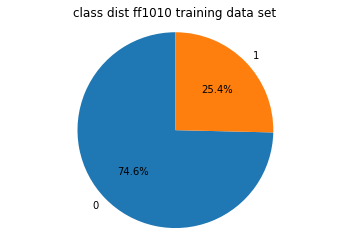

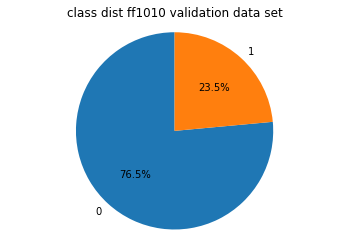

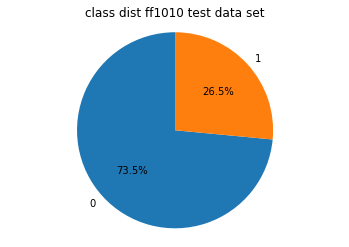

In [12]:
#Class imbalance

class_dist_ff = df_trLbl[0].value_counts()

fig,ax = plt.subplots()
ax.set_title('class dist ff1010 training data set')
ax.pie(class_dist_ff,labels=class_dist_ff.index, autopct = '%1.1f%%', 
       shadow = False, startangle=90)
ax.axis ('equal')
plt.show()

class_dist_ff = df_tvLbl[0].value_counts()

fig,ax = plt.subplots()
ax.set_title('class dist ff1010 validation data set')
ax.pie(class_dist_ff,labels=class_dist_ff.index, autopct = '%1.1f%%', 
       shadow = False, startangle=90)
ax.axis ('equal')
plt.show()

class_dist_ff = df_tsLbl[0].value_counts()

fig,ax = plt.subplots()
ax.set_title('class dist ff1010 test data set')
ax.pie(class_dist_ff,labels=class_dist_ff.index, autopct = '%1.1f%%', 
       shadow = False, startangle=90)
ax.axis ('equal')
plt.show()

In [13]:
trLbl_single

array([0, 0, 0, ..., 1, 1, 0], dtype=int64)

In [14]:
# class imbalance for training data setup
tr_class_wt = compute_class_weight('balanced',np.unique(trLbl_single),
                               trLbl_single)

## Step 3: Set up the model

### Approach 3.1: Convolution based model

In [15]:
# Extract frequency domain features convolution extraction based followed by 
# rounds of max2D pooling summarizations (frequency domain) 

In [234]:
# Seeding and optimizer selection

seed        = 29
np.random.seed(seed)

#adam
optmz       = optimizers.Adam(lr=0.001)
modelname   = 'Ajay_Singh_BirdAudioDetect_Model6.2-ConV2D'
filepath    = modelname + ".hdf5"

In [235]:
# Drop

In [236]:
print(trDat.shape[1],trDat.shape[2],trDat.shape[3])

40 499 1


In [237]:
def Conv2D_audiodetector():
    #1. Input shape vector: 
    #MFCC coeff x number of 40 ms (20ms interleaved) windows x 1 (for keras ...sake!) 
    
    I_P = Input(shape=(trDat.shape[1],trDat.shape[2],trDat.shape[3]))
    numClasses=2 # means two output classes: 2 0: No Bird Audio, 1: Bird Audio
    krnlsize=3 # means (3,3) kernel size
    strde=1 # means (1,1)stride
    pool_freq_compress =(2,1) # means vertical is compressed 2x(vertical is MFCC in our case)
    pool_freq_super_compress = (5,1) # means vertical is compressed 5x
    pool_temporal_super_compress = (1,5)
    
    v = Conv2D(96,
               kernel_size=krnlsize,
               strides= strde,
               padding='same',
               activation='relu',
               kernel_initializer='he_normal',
               kernel_regularizer=l2(1e-4),
               name='CL_1')(I_P)
    
    v = MaxPooling2D(pool_size=pool_freq_compress,
                        name='MPool_1')(v)
    
    v = Conv2D(96,
               kernel_size=krnlsize,
               strides= strde,
               padding='same',
               activation='relu',
               kernel_initializer='he_normal',
               kernel_regularizer=l2(1e-4),
               name='CL_2')(v)
    
    v = MaxPooling2D(pool_size=pool_freq_compress,
                        name='MPool_2')(v)
    
    v = Conv2D(96,
               kernel_size=krnlsize,
               strides= strde,
               padding='same',
               activation='relu',
               kernel_initializer='he_normal',
               kernel_regularizer=l2(1e-4),
               name='CL_3')(v)
    
    v = MaxPooling2D(pool_size=pool_freq_super_compress,
                        name='MPool_3')(v)
    
    v = Conv2D(96,
               kernel_size=krnlsize,
               strides= strde,
               padding='same',
               activation='relu',
               kernel_initializer='he_normal',
               kernel_regularizer=l2(1e-4),
               name='CL_4')(v)
    
    v = MaxPooling2D(pool_size=pool_freq_compress,
                        name='MPool_4')(v)
    
    v = MaxPooling2D(pool_size=pool_temporal_super_compress,
                        name='MPool_5')(v)
    
    v = MaxPooling2D(pool_size=pool_temporal_super_compress,
                        name='MPool_6')(v)
    
    v = MaxPooling2D(pool_size=pool_temporal_super_compress,
                        name='MPool_7')(v)
    
    #flatten the frame
    v = Flatten()(v)
    
    v = Dense(128,activation='relu',
              name='Dense_1')(v)
    
    v = BatchNormalization(name='bn_1')(v)
    
    v = Dense(64,activation='relu',
             name='Dense_2')(v)
    
    v = BatchNormalization(name='bn_2')(v)
    
    v = Dense(32,activation='relu',
             name='Dense_3')(v)
    
    
    outputs = Dense(numClasses,
                   activation='softmax',
                   kernel_initializer='he_normal')(v)
                  
    model = Model(inputs=I_P,outputs=outputs)
#     model.compile(loss='categorical_crossentropy',
#                  optimizer=optmz,
#                  metrics=['accuracy'])

    opt = SGD(lr=1e-2)
    model.compile(loss = "categorical_crossentropy", 
                  optimizer = opt,
                  metrics=['accuracy'])
    
    return model

## Step 4: Train the model

In [238]:
# 4.1 instantiate model
                                
model_conv       = Conv2D_audiodetector() 
model_conv.summary()
plot_model(model_conv, 
           to_file=modelname+'.png', 
           show_shapes=True, 
           show_layer_names=True,
           rankdir='TB')



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_34 (InputLayer)        (None, 40, 499, 1)        0         
_________________________________________________________________
CL_1 (Conv2D)                (None, 40, 499, 96)       960       
_________________________________________________________________
MPool_1 (MaxPooling2D)       (None, 20, 499, 96)       0         
_________________________________________________________________
CL_2 (Conv2D)                (None, 20, 499, 96)       83040     
_________________________________________________________________
MPool_2 (MaxPooling2D)       (None, 10, 499, 96)       0         
_________________________________________________________________
CL_3 (Conv2D)                (None, 10, 499, 96)       83040     
_________________________________________________________________
MPool_3 (MaxPooling2D)       (None, 2, 499, 96)        0         
__________

In [239]:
# 4.2 learning rate scheduler

def lrSchedule(epoch):
    lr  = 1e-3
    
    
    if epoch > 500:
        lr *= 0.5e-2
    elif epoch > 300:
        lr *= 1e-1
        
    elif epoch > 300:
        lr *= 0.5e-2
#     elif epoch > 200:
#         lr *= 1e-1
    
#     elif epoch > 160:
#         lr  *= 0.5e-2
        
#     elif epoch > 140:
#         lr  *= 1e-1
        
#     elif epoch > 120:
#         lr  *= 1e-1
        
#     elif epoch > 80:
#         lr  *= 1e-1
    
    return lr

LRScheduler     = LearningRateScheduler(lrSchedule)

In [240]:
# 4.3 This checkpoint performs model saving when
# an epoch gives highest testing accuracy

checkpoint      = ModelCheckpoint(filepath, 
                                  monitor='val_acc', 
                                  verbose=0, 
                                  save_best_only=True, 
                                  mode='max')

                            # Log the epoch detail into csv
csv_logger      = CSVLogger(modelname +'.csv')
callbacks_list  = [checkpoint,csv_logger,LRScheduler]

In [241]:
def generator(X_data, y_data, batch_size):

  samples_per_epoch = X_data.shape[0]
  number_of_batches = samples_per_epoch/batch_size
  counter=0

  while 1:

    X_batch = np.array(X_data[batch_size*counter:batch_size*(counter+1)]).astype('float32')
    y_batch = np.array(y_data[batch_size*counter:batch_size*(counter+1)]).astype('float32')
    counter += 1
    yield X_batch,y_batch

    #restart counter to yeild data in the next epoch as well
    if counter >= number_of_batches:
        counter = 0

In [242]:
#4.4 run the model

tr_class_wt = compute_class_weight('balanced',np.unique(trLbl_single),
                               trLbl_single)

model_conv.fit(trDat, trLbl, 
               batch_size = 32, 
               nb_epoch = 100,
               verbose = 2, 
               validation_data = (tvDat, tvLbl), 
               class_weight=tr_class_wt,
               callbacks=callbacks_list,)


# model_conv.fit_generator(generator(trDat,trLbl,batch_size=32),
#                          steps_per_epoch=len(trDat)/32,
#                          epochs=5,
#                          callbacks=callbacks_list,
#                          validation_data=(tvDat, tvLbl),
#                          verbose=1
#                          )

C:\Users\ajayv\.conda\envs\intelligentsensing\lib\site-packages\ipykernel_launcher.py:12: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  if sys.path[0] == '':


Train on 6010 samples, validate on 752 samples
Epoch 1/100
 - 16s - loss: 0.6212 - acc: 0.7642 - val_loss: 0.7078 - val_acc: 0.8019
Epoch 2/100
 - 13s - loss: 0.5610 - acc: 0.7940 - val_loss: 2.0330 - val_acc: 0.7646
Epoch 3/100
 - 13s - loss: 0.5389 - acc: 0.8103 - val_loss: 1.4032 - val_acc: 0.7673
Epoch 4/100
 - 13s - loss: 0.5255 - acc: 0.8123 - val_loss: 0.5330 - val_acc: 0.8125
Epoch 5/100
 - 13s - loss: 0.5088 - acc: 0.8260 - val_loss: 0.5820 - val_acc: 0.8191
Epoch 6/100
 - 13s - loss: 0.5046 - acc: 0.8255 - val_loss: 1.1963 - val_acc: 0.7646
Epoch 7/100
 - 13s - loss: 0.4985 - acc: 0.8270 - val_loss: 0.5245 - val_acc: 0.8098
Epoch 8/100
 - 13s - loss: 0.4912 - acc: 0.8291 - val_loss: 0.6696 - val_acc: 0.8059
Epoch 9/100
 - 13s - loss: 0.4830 - acc: 0.8348 - val_loss: 1.8858 - val_acc: 0.7646
Epoch 10/100
 - 14s - loss: 0.4778 - acc: 0.8363 - val_loss: 0.8354 - val_acc: 0.5771
Epoch 11/100
 - 14s - loss: 0.4666 - acc: 0.8408 - val_loss: 1.3285 - val_acc: 0.7713
Epoch 12/100
 - 

Epoch 96/100
 - 14s - loss: 0.3290 - acc: 0.8995 - val_loss: 0.5869 - val_acc: 0.8072
Epoch 97/100
 - 14s - loss: 0.2966 - acc: 0.9075 - val_loss: 2.4443 - val_acc: 0.7739
Epoch 98/100
 - 14s - loss: 0.3093 - acc: 0.9047 - val_loss: 0.7314 - val_acc: 0.7035
Epoch 99/100
 - 14s - loss: 0.2918 - acc: 0.9145 - val_loss: 5.0008 - val_acc: 0.2779
Epoch 100/100
 - 13s - loss: 0.2721 - acc: 0.9205 - val_loss: 5.1639 - val_acc: 0.2407


## Step 5: Test the model

In [245]:
# retrieve and load the model

#retreive the trained model parameters
filepath        = modelname + ".hdf5"

#instantiate
modelGo_conv     = Conv2D_audiodetector()
modelGo_conv.summary()

#load
modelGo_conv.load_weights(filepath)

#Compile
modelGo_conv.compile(loss='categorical_crossentropy', 
                optimizer=optmz, 
                metrics=['accuracy'])

# Make classification on the test dataset
predicts    = modelGo_conv.predict(tsDat)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_37 (InputLayer)        (None, 40, 499, 1)        0         
_________________________________________________________________
CL_1 (Conv2D)                (None, 40, 499, 96)       960       
_________________________________________________________________
MPool_1 (MaxPooling2D)       (None, 20, 499, 96)       0         
_________________________________________________________________
CL_2 (Conv2D)                (None, 20, 499, 96)       83040     
_________________________________________________________________
MPool_2 (MaxPooling2D)       (None, 10, 499, 96)       0         
_________________________________________________________________
CL_3 (Conv2D)                (None, 10, 499, 96)       83040     
_________________________________________________________________
MPool_3 (MaxPooling2D)       (None, 2, 499, 96)        0         
__________

## Step 6: Evaluate the model performance

In [246]:
# 1 Confusion matrix

# Prepare the classification output
# for the classification report
predout     = np.argmax(predicts,axis=1)
testout     = np.argmax(tsLbl,axis=1)
labelname   = ['No Bird Audio',
               'Bird Audio']

# the labels for the classfication report
testScores  = metrics.accuracy_score(testout,predout)
confusion   = metrics.confusion_matrix(testout,predout)


print("Best accuracy (on testing dataset): %.2f%%" % (testScores*100))
print(metrics.classification_report(testout,predout,target_names=labelname,digits=4))
print(confusion)

Best accuracy (on testing dataset): 84.29%
               precision    recall  f1-score   support

No Bird Audio     0.8412    0.9692    0.9007       552
   Bird Audio     0.8522    0.4925    0.6242       199

  avg / total     0.8441    0.8429    0.8274       751

[[535  17]
 [101  98]]


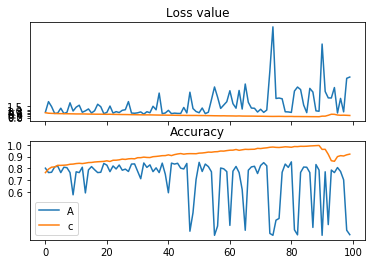

In [248]:


# Plot loss and accuracy
import pandas as pd

records     = pd.read_csv(modelname +'.csv')
plt.figure()

plt.subplot(211)
plt.plot(records['val_loss'])
plt.plot(records['loss'])
plt.yticks([0,0.20,0.40,0.60,0.80,1.00,1.5])
plt.title('Loss value',fontsize=12)

ax          = plt.gca()
ax.set_xticklabels([])




plt.subplot(212)
plt.plot(records['val_acc'])
plt.legend('Val_acc')
plt.plot(records['acc'])
plt.yticks([0.6,0.7,0.8,0.9,1.0])
plt.title('Accuracy',fontsize=12)
plt.legend('Acc')
plt.show()




In [249]:
# ROC AUC Charts


# y_true = testout# ground truth labels
# y_probas = predout
# skplt.metrics.plot_roc_curve(y_true, y_probas)
# plt.show()

In [250]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

fpr_keras, tpr_keras, thresholds_keras = roc_curve(testout, predout)
auc_keras = auc(fpr_keras, tpr_keras)

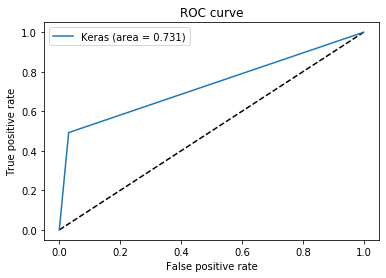

In [251]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
# Zoom in view of the upper left corner.
# plt.figure(2)
# plt.xlim(0, 0.2)
# plt.ylim(0.8, 1)
# plt.plot([0, 1], [0, 1], 'k--')
# plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
# plt.xlabel('False positive rate')
# plt.ylabel('True positive rate')
# plt.title('ROC curve (zoomed in at top left)')
# plt.legend(loc='best')
# plt.show()